# Sequence-to-sequence learning for PINNs
from: Characterizing possible failure modes in physics-informed neural networks, Krishnapriyan 2021 [https://doi.org/10.48550/arXiv.2109.01050]

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch import vmap
from torch.func import jacrev
import torch
from compute_error import compute_error_norms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def ODE_1(t, y): # Exponential decay
    # y: R^1, lambda: 0.1
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return -0.1 * y

ODE_1_y0 = torch.tensor([2.0]).to(device)

def ODE_2(t, y): # Van der Pol Oscillator
    # y: R^2, mu: 2
    if not isinstance(y, torch.Tensor):
        y = torch.tensor(y, dtype=torch.float32).to(device)
    
    x = y[0]
    dy = y[1]
    # Parameters
    omega = 1.0
    zeta = 0.5
    
    dydt = torch.stack([dy, -omega**2 * x - 2 * zeta * omega * dy]).to(device)
    return dydt

ODE_2_y0 = torch.tensor([2.0, 0.0]).to(device)

In [6]:
class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs,
        num_layers,
        num_neurons,
        num_outputs,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Basic neural network architecture with linear layers
        
        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # output layer
        layers.append(nn.Linear(num_neurons, num_outputs))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

In [7]:
model = LinearNN(1, 4, 64, 2).to(device)

# Define the Jacobian function for a single input
def jacobian_fn(x):
    return jacrev(model)(x)

# Use vmap to compute Jacobians for each element in the batch
batched_jacobian_fn = vmap(jacobian_fn)

In [8]:
ODE_batch = vmap(ODE_2, in_dims=0)

In [9]:
def loss_fn(t: torch.Tensor, initial_condition, start_T):
    # INTERIOR LOSS
    # NN grads
    y = model(t)
    
    jacobians = batched_jacobian_fn(t)
    dydt = jacobians.squeeze(-1)
    # ODE actual grads
    ode_grads = ODE_batch(t, y)
    interior = dydt - ode_grads
    
    # BOUNDARY LOSS
    y_0 = model(start_T)
    
    boundary = y_0 - initial_condition
    
    lambda_i = 1.0
    lambda_b = 5.0
    
    loss = nn.MSELoss(reduction='mean')
    interior_loss = loss(interior, torch.zeros_like(interior))
    boundary_loss = loss(boundary, torch.zeros_like(boundary))
    
    return lambda_i * interior_loss + lambda_b * boundary_loss
    

In [10]:
batch_size = 128  # number of colocation points to sample in the domain
num_iter = 50000  # maximum number of iterations
learning_rate = 1e-3  # learning rate
T = 10  # final time

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

delta_T = torch.tensor(1.0).to(device)
delta_T.requires_grad_(False)
start_T = torch.tensor(0.0).to(device)
start_T.requires_grad_(False)

loss_threshold = 1e-5

initial_condition = ODE_2_y0

while start_T < T:
    for i in range(num_iter):
        t = start_T + (torch.rand(batch_size, device=device) * delta_T)
        t.requires_grad_(True)
        
        loss = loss_fn(t, initial_condition, start_T)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f"Time: {start_T.item():.2f}, Iteration {i}, Loss: {loss.item():.6f}")
        
        if loss < loss_threshold:
            with torch.no_grad():
                initial_condition = model(start_T + delta_T)
            start_T += delta_T
            print(f"Advanced to T: {start_T.item():.2f} - Final Loss: {loss.item():.6f}")
            break
    
    if i == num_iter - 1:
        print(f"Warning: Did not converge for time window starting at {start_T.item():.2f}")

print(f"Training completed. Final time: {start_T.item():.2f}")


/home/vedo/miniconda3/envs/thesis/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Time: 0.00, Iteration 0, Loss: 12.175111
Time: 0.00, Iteration 10, Loss: 3.337867
Time: 0.00, Iteration 20, Loss: 1.861650
Time: 0.00, Iteration 30, Loss: 0.695291
Time: 0.00, Iteration 40, Loss: 0.342202
Time: 0.00, Iteration 50, Loss: 0.116793
Time: 0.00, Iteration 60, Loss: 0.089565
Time: 0.00, Iteration 70, Loss: 0.071829
Time: 0.00, Iteration 80, Loss: 0.044137
Time: 0.00, Iteration 90, Loss: 0.041790
Time: 0.00, Iteration 100, Loss: 0.019823
Time: 0.00, Iteration 110, Loss: 0.015751
Time: 0.00, Iteration 120, Loss: 0.006143
Time: 0.00, Iteration 130, Loss: 0.003448
Time: 0.00, Iteration 140, Loss: 0.002621
Time: 0.00, Iteration 150, Loss: 0.002207
Time: 0.00, Iteration 160, Loss: 0.002604
Time: 0.00, Iteration 170, Loss: 0.001732
Time: 0.00, Iteration 180, Loss: 0.002195
Time: 0.00, Iteration 190, Loss: 0.002143
Time: 0.00, Iteration 200, Loss: 0.001559
Time: 0.00, Iteration 210, Loss: 0.001807
Time: 0.00, Iteration 220, Loss: 0.002021
Time: 0.00, Iteration 230, Loss: 0.001678
Ti

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Solve the ODE system numerically
from scipy.integrate import solve_ivp

In [13]:
def ODE_1_np(t, y):
    dydt = ODE_1(t, y)
    return dydt.cpu().numpy()


def ODE_2_np(t,y):
    dydt = ODE_2(t, y)
    return dydt.cpu().numpy()

In [14]:
sol = solve_ivp(ODE_2_np, (0, T), ODE_2_y0.cpu().numpy(), method='RK45', t_eval=np.linspace(0, T, 100))

In [15]:
t = torch.linspace(0, T, 100).view(-1, 1).to(device)

t_np = t.cpu().detach().numpy()
y_pred_np = model(t).cpu().detach().numpy()


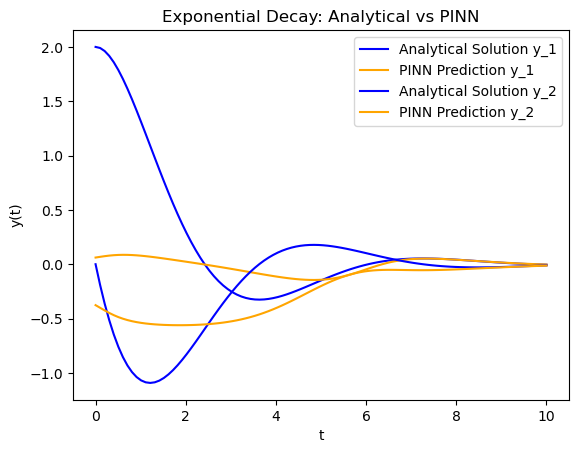

In [16]:
num_y = y_pred_np.shape[1]
for i in range(num_y):
    plt.plot(sol.t, sol.y.T[:, i], color='blue', label=f'Analytical Solution y_{i+1}')
    plt.plot(t_np, y_pred_np[:, i], color='orange', label=f'PINN Prediction y_{i+1}')

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.title('Exponential Decay: Analytical vs PINN')
plt.show()

In [17]:
error_norms = compute_error_norms(sol.y.T, y_pred_np, t_np)

In [18]:
error_norms

{'L1': {'y_1': 0.2983888009779168, 'y_2': 0.22031428447143575},
 'L2': {'y_1': 0.6074162796296969, 'y_2': 0.2897283145762747},
 'L1_avg': 0.2593515427246763,
 'L2_avg': 0.4485722971029858,
 'End_point_L1': {'y_1': 0.0010264739299018603, 'y_2': 0.0022843499887689224},
 'End_point_L2': {'y_1': 0.0010264739299018603, 'y_2': 0.0022843499887689224},
 'End_point_L1_avg': 0.0016554119593353914,
 'End_point_L2_avg': 0.0017708618805481054,
 'End_point_time': array([10.], dtype=float32)}